### Reference
CBBC Datasource - Goldman Sachs: https://www.gswarrants.com.hk/cgi/cbbc/cbbc_search.cgi

### EXAMPLE ON BULL CONTRACT
Example - 牛熊證編號：67102 騰訊法興九一R:
https://www.gswarrants.com.hk/cgi/cbbc/cbbc_indicator.cgi?code=67102 <br><br>
Expiration Date = 31/01/2019 <br>
Spot Price = 290.40 (16/11/2018 night) <br>
Strike = 253.20 <br>
Call Back = 256.00 <br>
Rato = 1:100 <br>
Per Unit: 10000 <br>
Transaction Fee = 0.02300 <br>
Cost = [(Spot Price - Strike) * Ratio + Transaction Fee] * Per Unit (HKD 3950) <br>

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import abupy

In [7]:
# PARAMETERS
SPOT_PRICE = 290.4
STRIKE = 253.20
CALL = 256.00
FUND = 0.023
RATIO = 1/100
UNIT = 10000
INIT_COST = ((SPOT_PRICE - STRIKE) * RATIO + FUND)* UNIT
# assume 50 periods/ days away from expiration date
PERIODS = 50

In [8]:
def get_cost(spot_price, strike, position, fund = 0.023, ratio = 1/100, unit = 10000):
    if position == 'long':
        init_cost = ((spot_price - strike) * ratio + fund) * unit
        return init_cost
    elif position == 'short':
        init_cost = ((strike - spot_price) * ratio + fund) * unit
        return init_cost

### PULL HK00700 DATA

In [9]:
# 7 Stocks with 2 years historical returns
choice_symbols = 'hk00700'
kl = abupy.ABuSymbolPd.make_kl_df(choice_symbols, n_folds=2)
tecent_ret_data = np.array(kl['p_change'])

### MONTE CARLO SIMULATION
Assume we are 50 periods (days) away from the expiration. (Assume each month contains 20 periods). By Monte Carlo simulation, we try to project the stock price of Tecent at expiration date. In this case, boostrap resampling is used.

In [10]:
# Input array of historical return >> Output array of simulated stock price path
def MonteCarlo_Sim(return_data, sim_num = 5000):
    sim_path_list = []
    for i in range(sim_num):
        # Random resampling historical return data
        rand_idx = np.random.choice(return_data.shape[0], PERIODS)
        ret_arr = return_data[rand_idx]
        ret_arr = 1 + (ret_arr/100)
        # Get cumulative return + 1 
        cum_mult = np.cumprod(ret_arr)
        # Get simulated stock price
        sim_path = SPOT_PRICE * cum_mult
        sim_path_list.append(sim_path)
    sim_path_list = np.array(sim_path_list)
    return sim_path_list

# Input array of simulated stock price >> Output array of simulated CBBC payoff
def CBBC_Payoff_Sim(sim_path_list):
    sim_payoff_list = []
    mult = RATIO * UNIT
    for sim_path in sim_path_list:
        # Check if the path ever touches on CALL level
        if np.sum(sim_path <= CALL):
            payoff = 0
            sim_payoff_list.append(payoff)
        else:
            ult_price = sim_path[-1]
            payoff = (ult_price - STRIKE) * mult
            sim_payoff_list.append(payoff)
    sim_payoff_list = np.array(sim_payoff_list)
    return sim_payoff_list

# Input array of simulated CBBC payoff >> Output array of simulated return
def CBBC_Return_Sim(sim_payoff_list):
    # convert from decimal to %
    sim_return_list = (sim_payoff_list / INIT_COST - 1) * 100
    return sim_return_list

In [11]:
sim_path_list = MonteCarlo_Sim(tecent_ret_data)
sim_payoff_list = CBBC_Payoff_Sim(sim_path_list)
sim_return_list = CBBC_Return_Sim(sim_payoff_list)

### VISAULIZATIONS

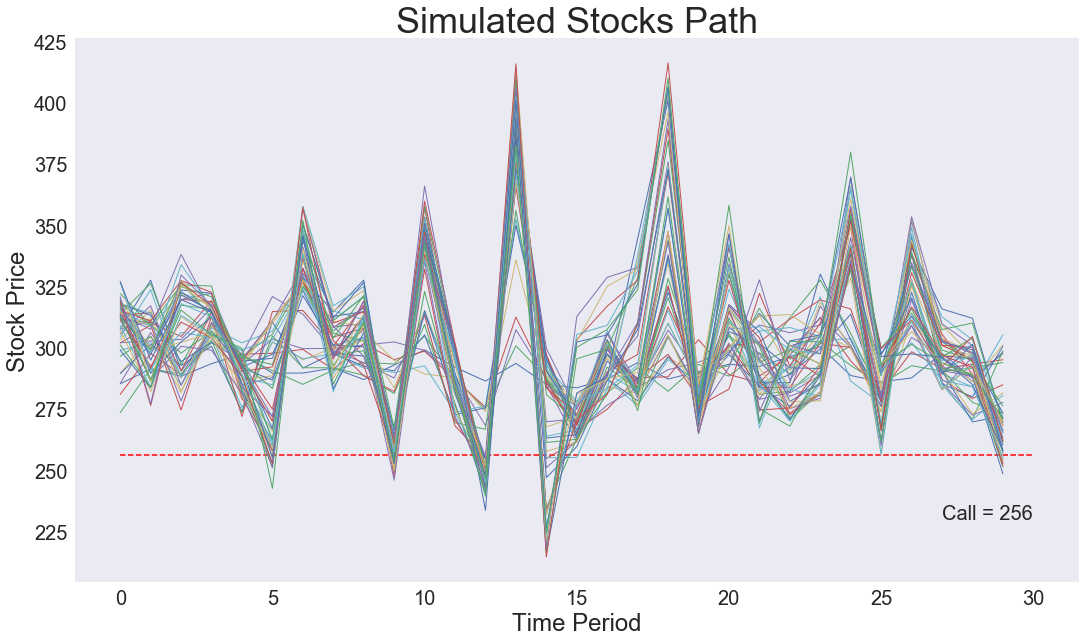

In [12]:
# Inspect the first 20 simulated stock path
plt.figure(figsize = (18, 10))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid(False)
plt.plot(sim_path_list[:30], linewidth = 1)
# Draw a Call Level line
plt.hlines(256, 0, 30, color = 'r', linewidth = 1.5, linestyle = '--')
plt.text(27, 230, 'Call = 256', fontdict = {'fontsize': 20})
plt.title('Simulated Stocks Path', fontsize = 36)
plt.xlabel('Time Period', fontsize = 24)
plt.ylabel('Stock Price', fontsize = 24);

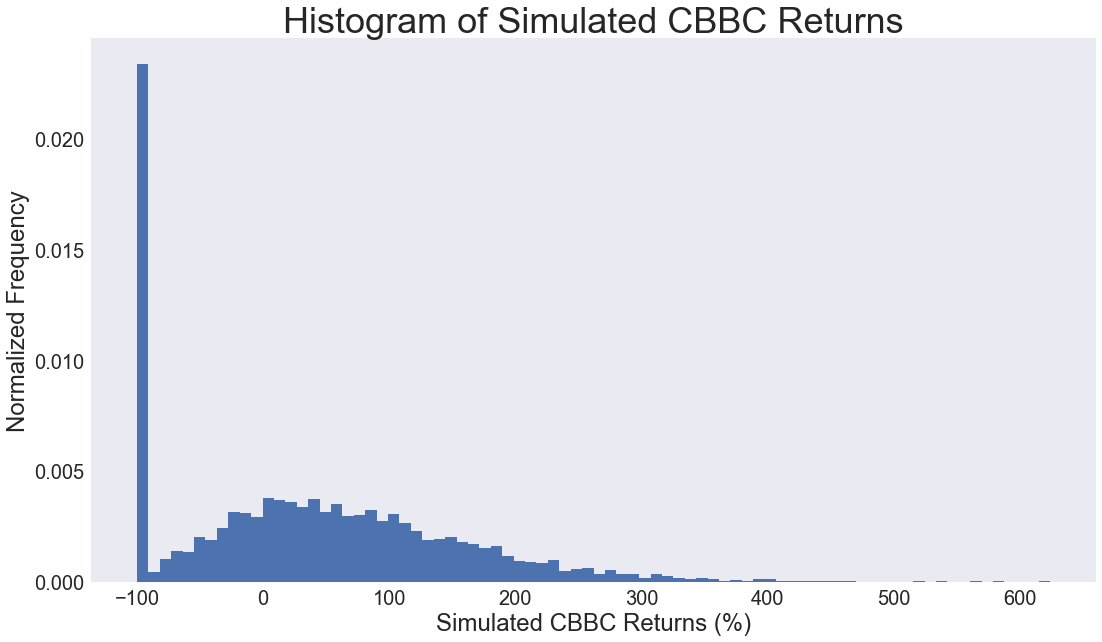

In [13]:
plt.figure(figsize = (18, 10))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid(False)
plt.hist(sim_return_list, bins = 80, normed=True)
plt.title('Histogram of Simulated CBBC Returns', fontsize = 36)
plt.xlabel('Simulated CBBC Returns (%)', fontsize = 24)
plt.ylabel('Normalized Frequency', fontsize = 24);

1. Underlying Stock Return Histogram
2. Visualise path diminish after call level hits


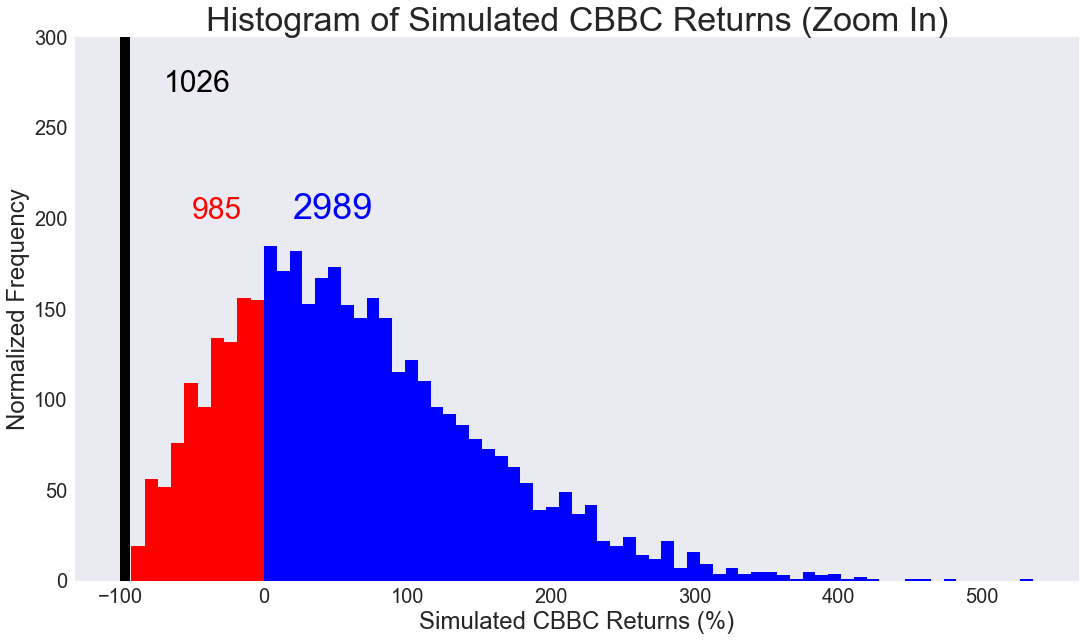

In [263]:
pos_sim_ret = sim_return_list[sim_return_list > 0]
neg_sim_ret = sim_return_list[(sim_return_list <= 0) & (sim_return_list != -100)]
zero_sim_ret = sim_return_list[sim_return_list == -100]
pos_num = len(pos_sim_ret)
neg_num = len(neg_sim_ret)
zero_num = len(zero_sim_ret)

# Zoom in the plot for closer inspection
plt.figure(figsize = (18, 10))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylim(0, 300)
plt.grid(False)
plt.hist(pos_sim_ret, bins = 60, color = 'blue')
plt.hist(neg_sim_ret, bins = 10, color ='red')
plt.hist(zero_sim_ret, bins = [-100, -93] , range = (-100.5, -99.5), color = 'black', )
plt.title('Histogram of Simulated CBBC Returns (Zoom In)', fontsize = 34)

# Plot text
plt.text(-50, 200, str(neg_num), fontdict = {'fontsize': 30}, color = 'red')
plt.text(20, 200, str(pos_num), fontdict = {'fontsize': 36}, color = 'blue')
plt.text(-70, 270, str(zero_num), fontdict = {'fontsize': 30}, color = 'black')

plt.xlabel('Simulated CBBC Returns (%)', fontsize = 24)
plt.ylabel('Normalized Frequency', fontsize = 24);